In [1]:
pip install transformers


[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install seaborn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 5.8 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from transformers import pipeline

from nltk import sent_tokenize
import nltk
from time import time
import matplotlib.pyplot as plt
import torch

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [5]:
import nltk
nltk.download()

2024-05-05 00:39:25.620 Python[70922:3800598] WARNING: Secure coding is not enabled for restorable state! Enable secure coding by implementing NSApplicationDelegate.applicationSupportsSecureRestorableState: and returning YES.


showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


True

In [4]:
!bash '/Applications/Python 3.10/Install Certificates.command'

 -- pip install --upgrade certifi

[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip3 install --upgrade pip
 -- removing any existing file or link
 -- creating symlink to certifi certificate bundle
 -- setting permissions
 -- update complete


In [2]:
substitles_paths = sorted(glob("Subtitles/*.ass"))

In [3]:
scripts = []  # List to store extracted scripts
episode_num = []  # List to store episode numbers

for path in substitles_paths:  # Iterate through each subtitle file path
    
    with open(path,'r') as file:  # Open the file
        lines = file.readlines()  # Read all lines
        lines = lines[27:]  # Skip header lines
        
        rows = [",".join(line.split(',')[9:]) for line in lines]  # Extract dialogue rows
        
    rows = [line.replace("\\N",' ') for line in rows]  # Replace "\N" with space in each row
    script = " ".join(rows)  # Combine rows into a single script
    
    episode = int(path.split('-')[1].split('.')[0].strip())  # Extract episode number from file name
    
    scripts.append(script)  # Add script to scripts list
    episode_num.append(episode)  # Add episode number to episode_num list


In [4]:
# Creating a DataFrame from a dictionary with 'episode' and 'script' keys
df = pd.DataFrame.from_dict({'episode':episode_num,'script':scripts})

In [5]:
df.head()

,episode,script
0,1,"A long time ago, a powerful demon fox appeared..."
1,2,"C'mon!\n Running like a fugitive,\n Being chas..."
2,3,"C'mon!\n Running like a fugitive,\n Being chas..."
3,4,"C'mon!\n Running like a fugitive,\n Being chas..."
4,5,"C'mon!\n Running like a fugitive,\n Being chas..."


In [6]:
device = 0 if torch.cuda.is_available() else 'cpu'

In [7]:
from transformers import pipeline
# Creating a theme_classifier pipeline using zero-shot classification with the specified model and device
theme_classifier = pipeline("zero-shot-classification",
                      model= 'facebook/bart-large-mnli',
                      device=device)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [8]:
theme_classifier("I have a problem with my iphone that needs to be resolved asap!",
    candidate_labels=["urgent", "not urgent", "phone", "tablet", "computer"],
    multi_label=False
)

{'sequence': 'I have a problem with my iphone that needs to be resolved asap!',
 'labels': ['urgent', 'phone', 'computer', 'not urgent', 'tablet'],
 'scores': [0.5227581262588501,
  0.4581402838230133,
  0.01426456868648529,
  0.002685012761503458,
  0.002152057597413659]}

In [9]:
def get_themes(script):
    # Tokenize script into sentences
    script_sentences = sent_tokenize(script)

    # Batch sentences 
    script_batches = []
    sentence_batch_size=20
    for index in range(0,len(script_sentences),sentence_batch_size):
        # Combine sentences into batches of size 20
        sent = " ".join(script_sentences[index:index+sentence_batch_size])
        script_batches.append(sent)
    
    # Run theme classifier model
    candidate_labels = ['friendship','hope', 'sacrifice', 'battle','self development','betrayal','love','dialogue'] 
    emotion_output = theme_classifier(script_batches, 
                                      candidate_labels,
                                      multi_label=True)

    # Wrangle Output    
    emotions={}
    for output in  emotion_output:
        # Extract labels and scores from each output
        for label, score in zip(output['labels'],output['scores']):
            if label not in emotions:
                # If label is not yet in emotions dictionary, add it as a key with an empty list
                emotions[label]=[]
            # Append score to the list of scores for the corresponding label
            emotions[label].append(score)
    
    # Calculate mean score for each emotion
    emotions = {key:np.mean(np.array(value)) for key,value in emotions.items()}
   
    return emotions


In [10]:
# Applying the get_themes function to each script in the DataFrame and storing the output in output_emotions
output_emotions = df['script'].apply(get_themes)

In [11]:
# Creating a DataFrame from the list of dictionaries stored in output_emotions
emotion_df = pd.DataFrame(output_emotions.tolist())

In [12]:
emotion_df.head()

,dialogue,betrayal,battle,sacrifice,self development,hope,friendship,love
0,0.933066,0.843437,0.730704,0.738852,0.786692,0.356776,0.270747,0.171008
1,0.878907,0.523090,0.614092,0.560679,0.723524,0.360577,0.199374,0.126210
2,0.914471,0.591376,0.700836,0.721965,0.739590,0.379513,0.339813,0.260938
3,0.704727,0.346729,0.641507,0.494500,0.496161,0.230441,0.110954,0.133851
4,0.818598,0.680575,0.750628,0.708858,0.653923,0.301845,0.238132,0.113576


In [13]:
# Adding the columns from emotion_df to the original DataFrame df
df[emotion_df.columns] = emotion_df


In [14]:
# Dropping 'episode', 'script', and 'dialogue' columns from df and summing up the remaining columns
theme_output = df.drop(['episode','script','dialogue'],axis=1).sum().reset_index()

# Renaming columns to 'theme' and 'score'
theme_output.columns = ['theme','score']

# Assigning the resulting DataFrame to theme_output
theme_output


,theme,score
0,betrayal,123.675218
1,battle,154.715291
2,sacrifice,158.352691
3,self development,145.778681
4,hope,89.346000
5,friendship,75.649774
6,love,46.516863


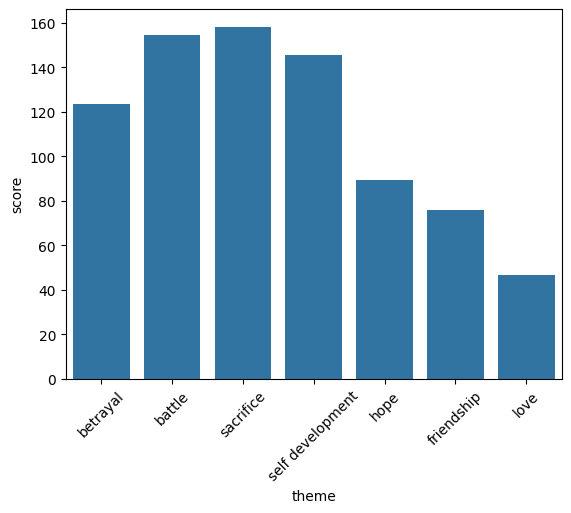

In [15]:
import seaborn as sns

#plots the main themes and their scores
sns.barplot(data=theme_output, x="theme", y="score")
plt.xticks(rotation=45)
plt.show()